# Introduction
### Content: This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV.
#### Description: The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

## Data:
### Date - The date of the observation
### AveragePrice - the average price of a single avocado
### type - conventional or organic
### year - the year
### Region - the city or region of the observation
### Total Volume - Total number of avocados sold
### 4046 - Total number of avocados with PLU 4046 sold (small)
### 4225 - Total number of avocados with PLU 4225 sold (medium)
### 4770 - Total number of avocados with PLU 4770 sold (large)

In [148]:
%%R
df <- read.csv("/content/drive/MyDrive/avocado.csv")
head(df)

  X       Date AveragePrice Total.Volume   X4046     X4225  X4770 Total.Bags
1 0 2015-12-27         1.33     64236.62 1036.74  54454.85  48.16    8696.87
2 1 2015-12-20         1.35     54876.98  674.28  44638.81  58.33    9505.56
3 2 2015-12-13         0.93    118220.22  794.70 109149.67 130.50    8145.35
4 3 2015-12-06         1.08     78992.15 1132.00  71976.41  72.58    5811.16
5 4 2015-11-29         1.28     51039.60  941.48  43838.39  75.78    6183.95
6 5 2015-11-22         1.26     55979.78 1184.27  48067.99  43.61    6683.91
  Small.Bags Large.Bags XLarge.Bags         type year region
1    8603.62      93.25           0 conventional 2015 Albany
2    9408.07      97.49           0 conventional 2015 Albany
3    8042.21     103.14           0 conventional 2015 Albany
4    5677.40     133.76           0 conventional 2015 Albany
5    5986.26     197.69           0 conventional 2015 Albany
6    6556.47     127.44           0 conventional 2015 Albany


## Split test/train data

In [206]:
%%R
set.seed(125)
train_index <- sample(1:nrow(df), 0.8 * nrow(df))
train_data <- df[train_index,]
test_data <- df[-train_index,]
print(nrow(train_data))
print(nrow(test_data))

[1] 14599
[1] 3650


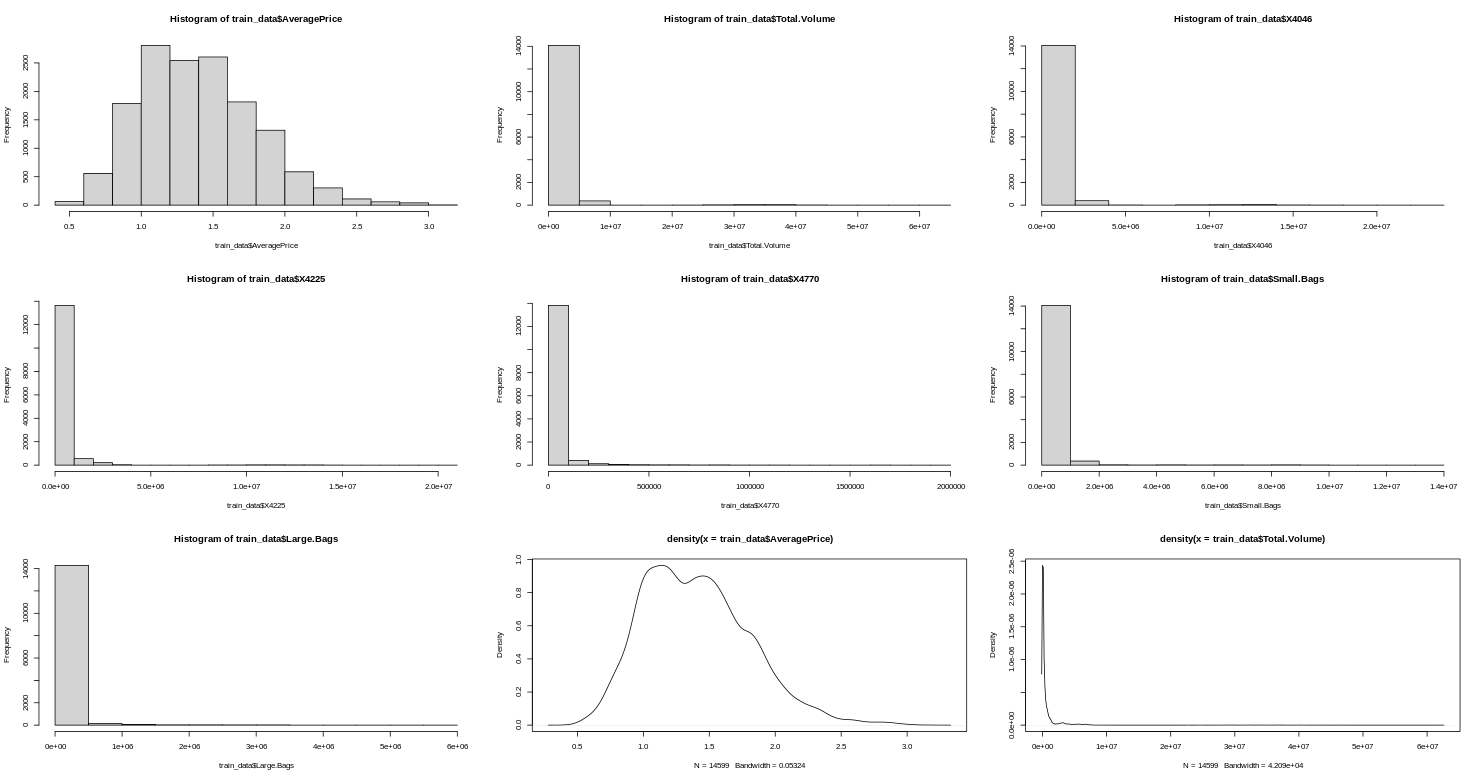

In [207]:
%%R -w 1480 -h 780 -u px
par(mfrow=c(3,3))
hist(train_data$AveragePrice)
hist(train_data$Total.Volume)
hist(train_data$X4046)
hist(train_data$X4225)
hist(train_data$X4770)
hist(train_data$Small.Bags)
hist(train_data$Large.Bags)
plot(density(train_data$AveragePrice))
plot(density(train_data$Total.Volume))

## Logistic tranformations

In [208]:
%%R
train_data <- transform(train_data, ln_Tot_Vol = log(Total.Volume))
train_data <- transform(train_data, ln_Tot_Small = log(X4046))
train_data <- transform(train_data, ln_Tot_Med = log(X4225))
train_data <- transform(train_data, ln_Small_Bags = log(Small.Bags))
train_data <- transform(train_data, ln_Large_Bags = log(Large.Bags))
train_data$date <- ymd(train_data$Date)
train_data$month <- format(as.Date(train_data$date, format="%Y-%m-%d"),"%m")
train_data$month <- as.numeric(train_data$month)

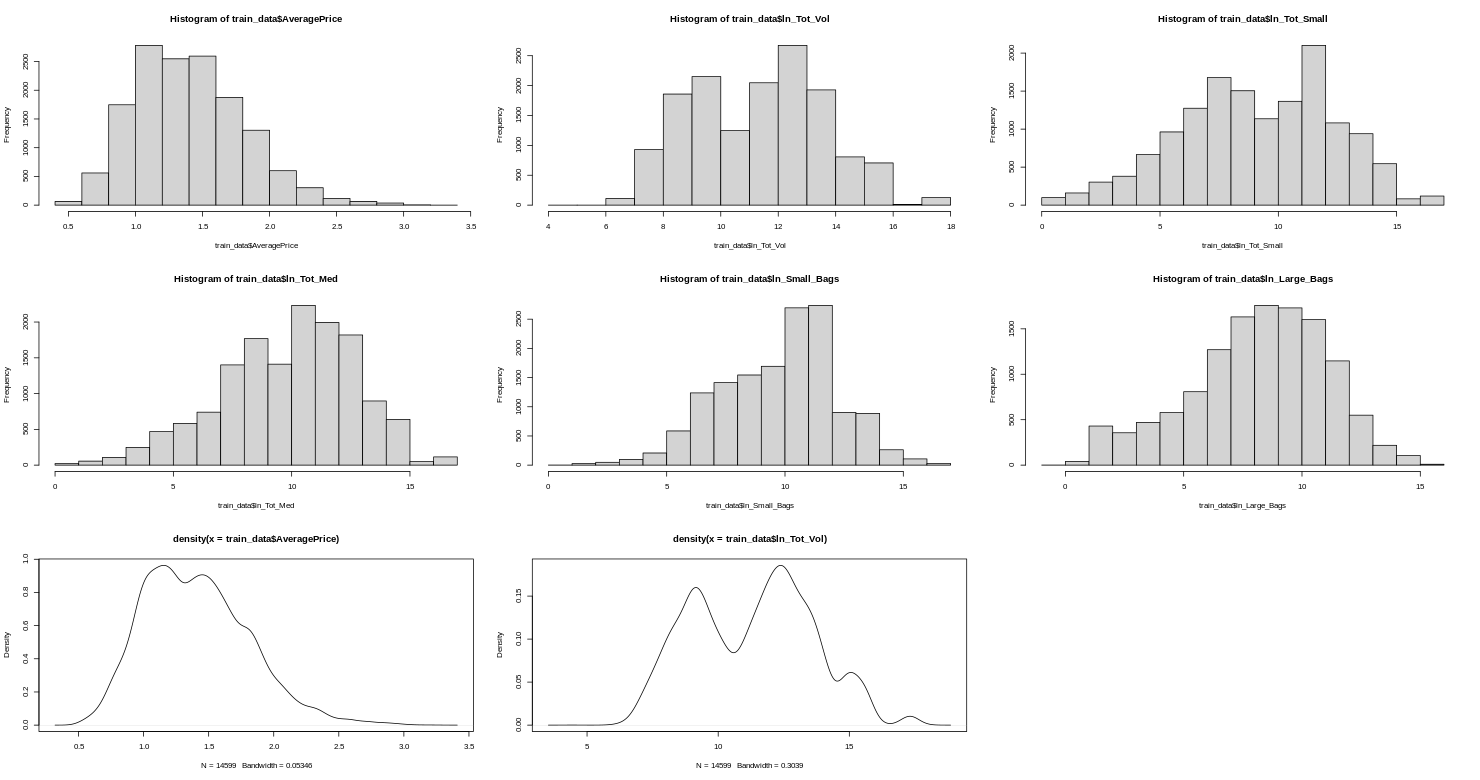

In [152]:
%%R -w 1480 -h 780 -u px
par(mfrow=c(3,3))
hist(train_data$AveragePrice)
hist(train_data$ln_Tot_Vol)
hist(train_data$ln_Tot_Small)
hist(train_data$ln_Tot_Med)
hist(train_data$ln_Small_Bags)
hist(train_data$ln_Large_Bags)
plot(density(train_data$AveragePrice))
plot(density(train_data$ln_Tot_Vol))

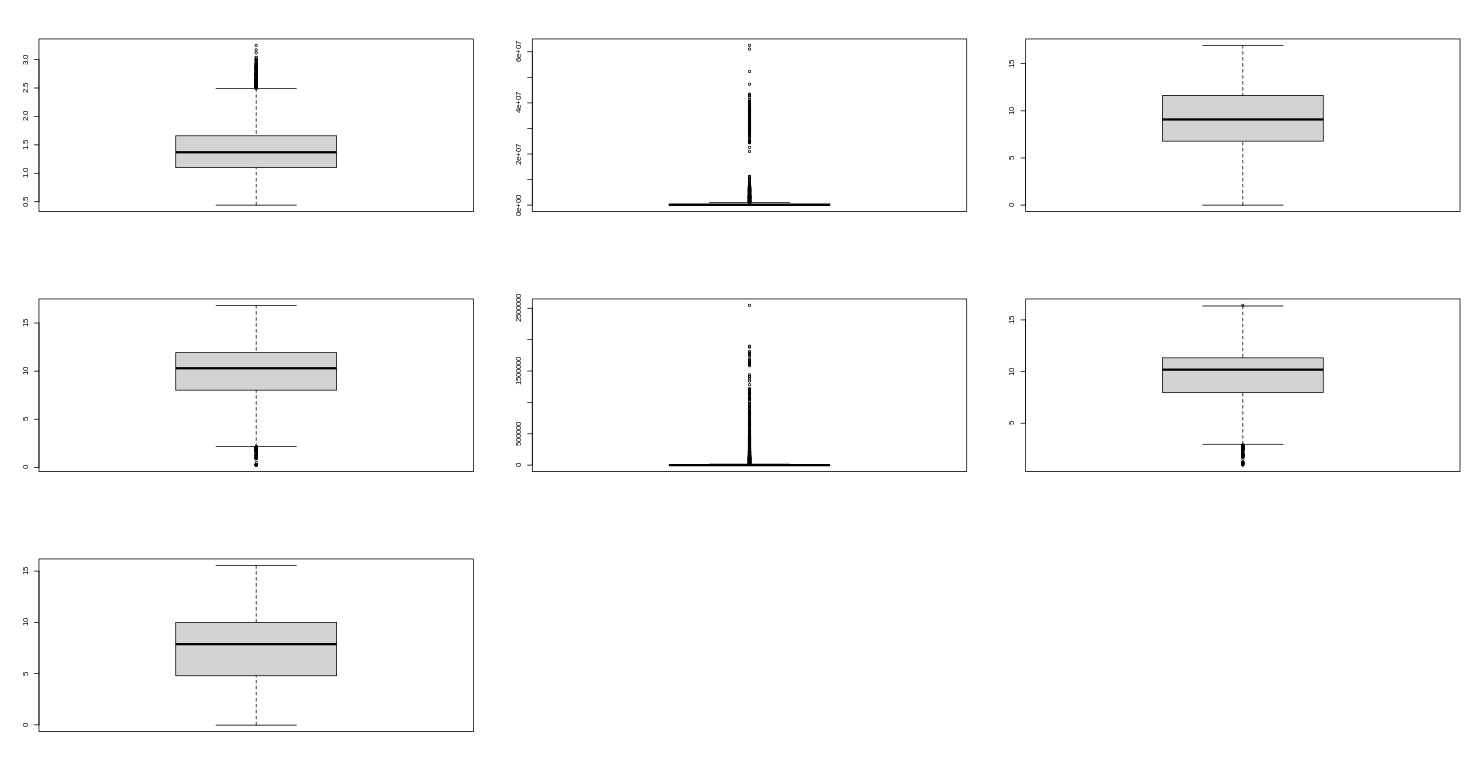

In [49]:
%%R -w 1480 -h 780 -u px
par(mfrow=c(3,3))
boxplot(train_data$AveragePrice, xlab="AveragePrice")
boxplot(train_data$Total.Volume, xlab="Total.Volume")
boxplot(train_data$ln_Tot_Small, xlab="ln_Tot_Small")
boxplot(train_data$ln_Tot_Med, xlab="ln_Tot_Med")
boxplot(train_data$X4770, xlab="X4770")
boxplot(train_data$ln_Small_Bags,xlab="ln_Small_Bags")
boxplot(train_data$ln_Large_Bags, xlab="ln_Large_Bags")

## Remove Outliers Using IQR

In [209]:
%%R
detect_outlier <- function(x,iqtimes=1.5) {
  Quantile1 <- quantile(x, probs=.25, na.rm = T)
  Quantile3 <- quantile(x, probs=.75, na.rm = T)

  IQR = Quantile3-Quantile1

  outiers <- x > Quantile3 + (IQR*iqtimes) | x < Quantile1 - (IQR*iqtimes)
  x[which(outiers)] <- NA
  return(x)
}

In [210]:
%%R
cols_to_clean <- names(train_data)[sapply(train_data , is.numeric)]
data_clean<- train_data %>%
  mutate(across(cols_to_clean , ~detect_outlier(.,iqtimes=1.5)))
data_clean <- na.omit(data_clean)

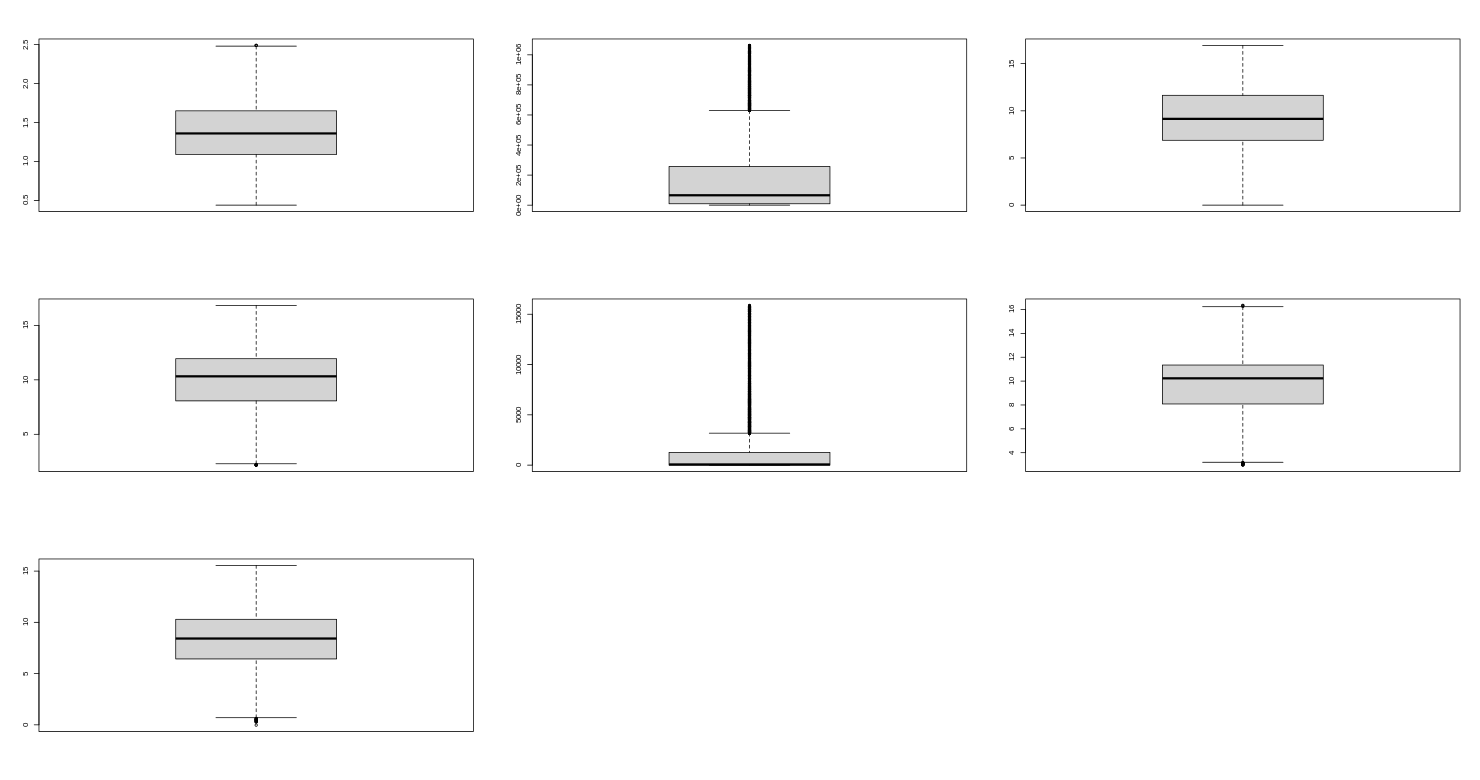

In [52]:
%%R -w 1480 -h 780 -u px
par(mfrow=c(3,3))
boxplot(data_clean$AveragePrice)
boxplot(data_clean$Total.Volume)
boxplot(data_clean$ln_Tot_Small)
boxplot(data_clean$ln_Tot_Med)
boxplot(data_clean$X4770)
boxplot(data_clean$ln_Small_Bags)
boxplot(data_clean$ln_Large_Bags)

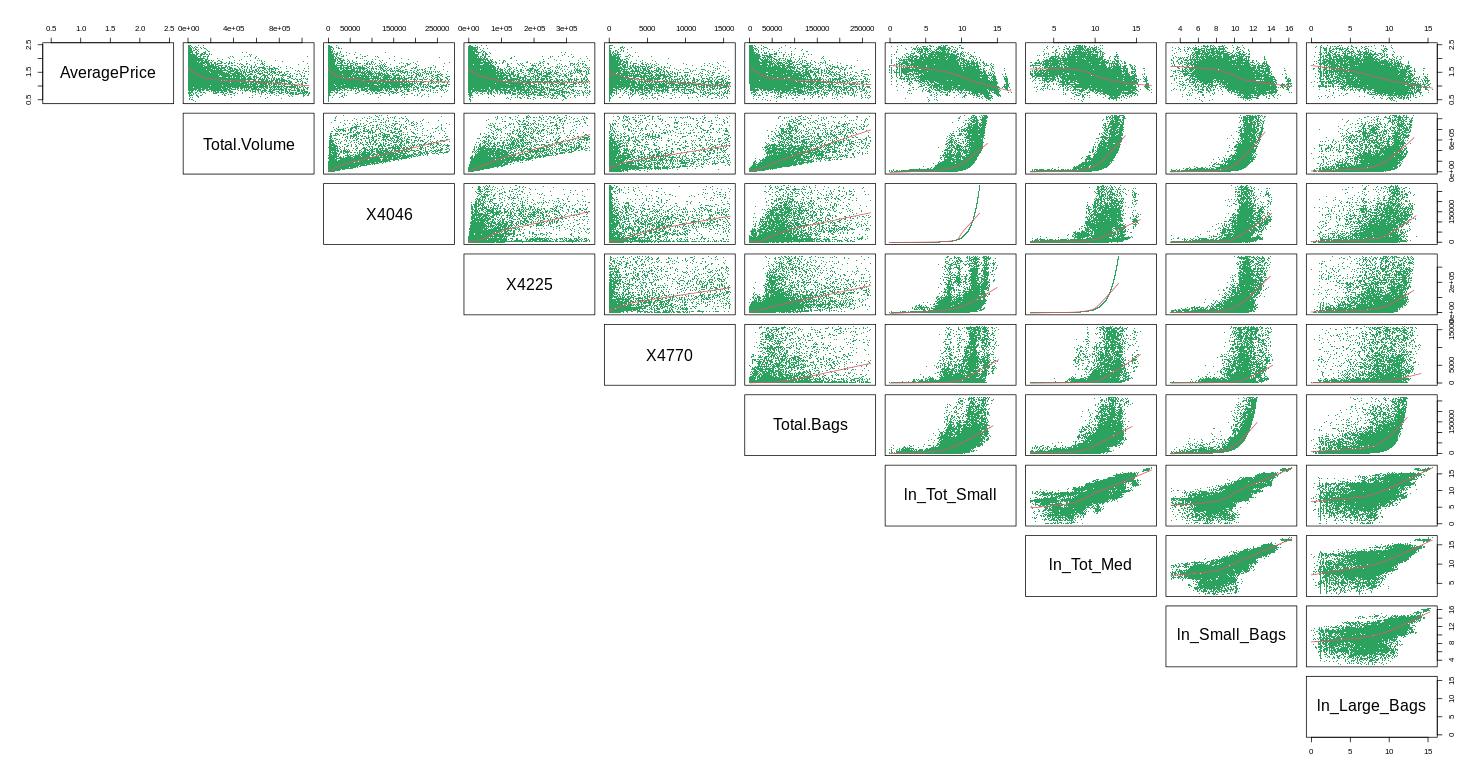

In [53]:
%%R -w 1480 -h 780 -u px
df_c <- data_clean[, c('AveragePrice', 'Total.Volume', 'X4046', 'X4225', 'X4770','Total.Bags','ln_Tot_Small', 'ln_Tot_Med', 'ln_Small_Bags', 'ln_Large_Bags')]
pairs(df_c, pch = '.', upper.panel = panel.smooth, lower.panel = NULL,  col = '#2CA25F')

In [211]:
%%R
model_1 <- lm(AveragePrice ~  Total.Volume + X4770 + type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags, data= data_clean, na.action = na.omit)
summary(model_1)


Call:
lm(formula = AveragePrice ~ Total.Volume + X4770 + type + region + 
    month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags, 
    data = data_clean, na.action = na.omit)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81771 -0.15576 -0.01146  0.14023  0.94422 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.509e+00  6.856e-02  22.013  < 2e-16 ***
Total.Volume              -7.513e-07  5.968e-08 -12.590  < 2e-16 ***
X4770                     -7.118e-06  1.656e-06  -4.298 1.74e-05 ***
typeorganic                1.419e-01  2.889e-02   4.911 9.26e-07 ***
regionAtlanta              7.326e-02  3.715e-02   1.972 0.048613 *  
regionBaltimoreWashington  1.955e-01  3.911e-02   4.997 5.96e-07 ***
regionBoise               -7.416e-02  3.066e-02  -2.419 0.015607 *  
regionBoston               2.434e-01  3.597e-02   6.766 1.43e-11 ***
regionBuffaloRochester     1.091e-01  3.238e-02   3.370 0.000756 ***


In [212]:
%%R
model_2 <- lm(AveragePrice ~  type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags, data= data_clean)
summary(model_2)


Call:
lm(formula = AveragePrice ~ type + region + month + ln_Tot_Small + 
    ln_Tot_Med + ln_Small_Bags + ln_Large_Bags, data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8197 -0.1606 -0.0117  0.1444  0.9807 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.5896978  0.0678351  23.435  < 2e-16 ***
typeorganic                0.2570709  0.0280817   9.154  < 2e-16 ***
regionAtlanta             -0.0180503  0.0372623  -0.484 0.628109    
regionBaltimoreWashington  0.1073422  0.0392342   2.736 0.006236 ** 
regionBoise               -0.1372679  0.0306776  -4.475 7.78e-06 ***
regionBoston               0.1192150  0.0356264   3.346 0.000823 ***
regionBuffaloRochester     0.0515417  0.0326766   1.577 0.114765    
regionCalifornia           0.1795027  0.0491687   3.651 0.000263 ***
regionCharlotte            0.1937676  0.0352126   5.503 3.87e-08 ***
regionChicago              0.0003456  0.0515357   0.007 0.9

### Hypothesis Testing: Nested Models


In [213]:
%%R
anova(model_2,model_1)

Analysis of Variance Table

Model 1: AveragePrice ~ type + region + month + ln_Tot_Small + ln_Tot_Med + 
    ln_Small_Bags + ln_Large_Bags
Model 2: AveragePrice ~ Total.Volume + X4770 + type + region + month + 
    ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1   7041 436.33                                  
2   7039 422.16  2    14.163 118.07 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Stepwise Comparison of Models

In [101]:
%%R
m1 <- lm(AveragePrice ~  type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags, data= data_clean)
m2 <- step(m1, scope = list(
  lower = AveragePrice ~ 1,
  upper = AveragePrice ~ (type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags)^2
))

Start:  AIC=-19782.48
AveragePrice ~ type + region + month + ln_Tot_Small + ln_Tot_Med + 
    ln_Small_Bags + ln_Large_Bags

                              Df Sum of Sq    RSS    AIC
+ region:ln_Tot_Med           53    37.567 392.59 -20325
+ region:ln_Large_Bags        53    34.975 395.18 -20278
+ region:ln_Tot_Small         53    32.249 397.91 -20230
+ ln_Small_Bags:ln_Large_Bags  1    23.942 406.21 -20187
+ region:ln_Small_Bags        53    27.726 402.43 -20150
+ type:region                 36    24.761 405.40 -20131
+ type:ln_Large_Bags           1    15.661 414.49 -20044
+ ln_Tot_Small:ln_Tot_Med      1     8.915 421.24 -19929
+ region:month                53    13.448 416.71 -19902
+ type:ln_Tot_Med              1     6.039 424.12 -19881
+ type:ln_Small_Bags           1     2.215 427.94 -19817
+ ln_Tot_Small:ln_Large_Bags   1     2.150 428.01 -19816
+ ln_Tot_Small:ln_Small_Bags   1     2.089 428.07 -19815
+ ln_Tot_Med:ln_Small_Bags     1     0.715 429.44 -19792
+ type:ln_Tot_Small 

In [214]:
%%R
model_3 <- lm(AveragePrice ~  type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags + region:type, data= data_clean)
summary(model_3)


Call:
lm(formula = AveragePrice ~ type + region + month + ln_Tot_Small + 
    ln_Tot_Med + ln_Small_Bags + ln_Large_Bags + region:type, 
    data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90031 -0.14839 -0.01318  0.13383  1.04253 

Coefficients: (16 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            1.8856545  0.0768131  24.549  < 2e-16
typeorganic                            0.0731938  0.0878158   0.833 0.404596
regionAtlanta                         -0.0462157  0.0701772  -0.659 0.510202
regionBaltimoreWashington              0.2195535  0.1129343   1.944 0.051926
regionBoise                           -0.2451908  0.0387790  -6.323 2.73e-10
regionBoston                           0.0997074  0.0563232   1.770 0.076725
regionBuffaloRochester                 0.1401068  0.0398397   3.517 0.000440
regionCalifornia                       0.3607024  0.0901454   

## Hypothesis Testing Non Embedded Models

In [215]:
%%R
anova(model_2, model_3)

Analysis of Variance Table

Model 1: AveragePrice ~ type + region + month + ln_Tot_Small + ln_Tot_Med + 
    ln_Small_Bags + ln_Large_Bags
Model 2: AveragePrice ~ type + region + month + ln_Tot_Small + ln_Tot_Med + 
    ln_Small_Bags + ln_Large_Bags + region:type
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1   7041 436.33                                  
2   7004 412.45 37    23.875 10.957 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [230]:
%%R
print(AIC(model_2))
print(AIC(model_3))

[1] 464.809
[1] 139.2277


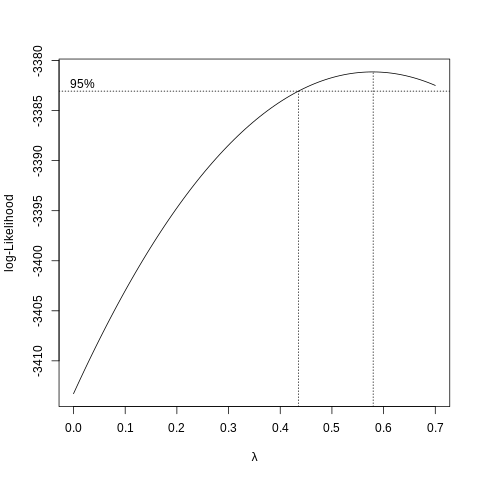

In [232]:
%%R
boxcox(model_2, lambda = seq(0,.7,by=.1))

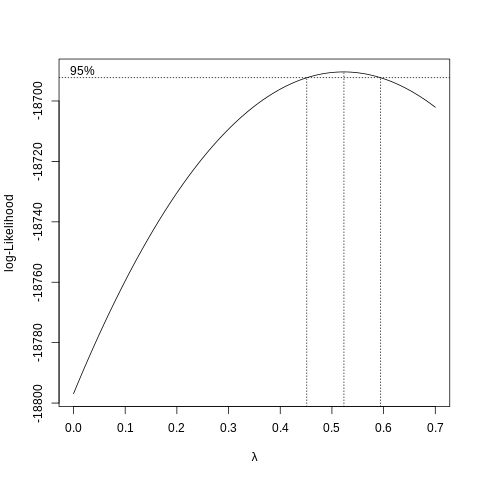

In [216]:
%%R
boxcox(model_3, lambda = seq(0,.7,by=.1))

In [217]:
%%R
lambda = .51
model_4 <- lm(((AveragePrice^lambda - 1) / lambda)~  type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags + region:type, data= data_clean)
summary(model_4)


Call:
lm(formula = ((AveragePrice^lambda - 1)/lambda) ~ type + region + 
    month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags + 
    region:type, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.88000 -0.12003 -0.00555  0.11582  0.77280 

Coefficients: (16 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            0.7981009  0.0634168  12.585  < 2e-16
typeorganic                            0.0387646  0.0725007   0.535 0.592889
regionAtlanta                         -0.0568461  0.0579382  -0.981 0.326553
regionBaltimoreWashington              0.1979259  0.0932385   2.123 0.033806
regionBoise                           -0.2418827  0.0320159  -7.555 4.72e-14
regionBoston                           0.0910750  0.0465004   1.959 0.050201
regionBuffaloRochester                 0.1233634  0.0328916   3.751 0.000178
regionCalifornia                       0

In [218]:
%%R
print(AIC(model_1))
print(AIC(model_2))
print(AIC(model_3))
print(AIC(model_4))

[1] 234.4942
[1] 464.809
[1] 139.2277
[1] -2582.519


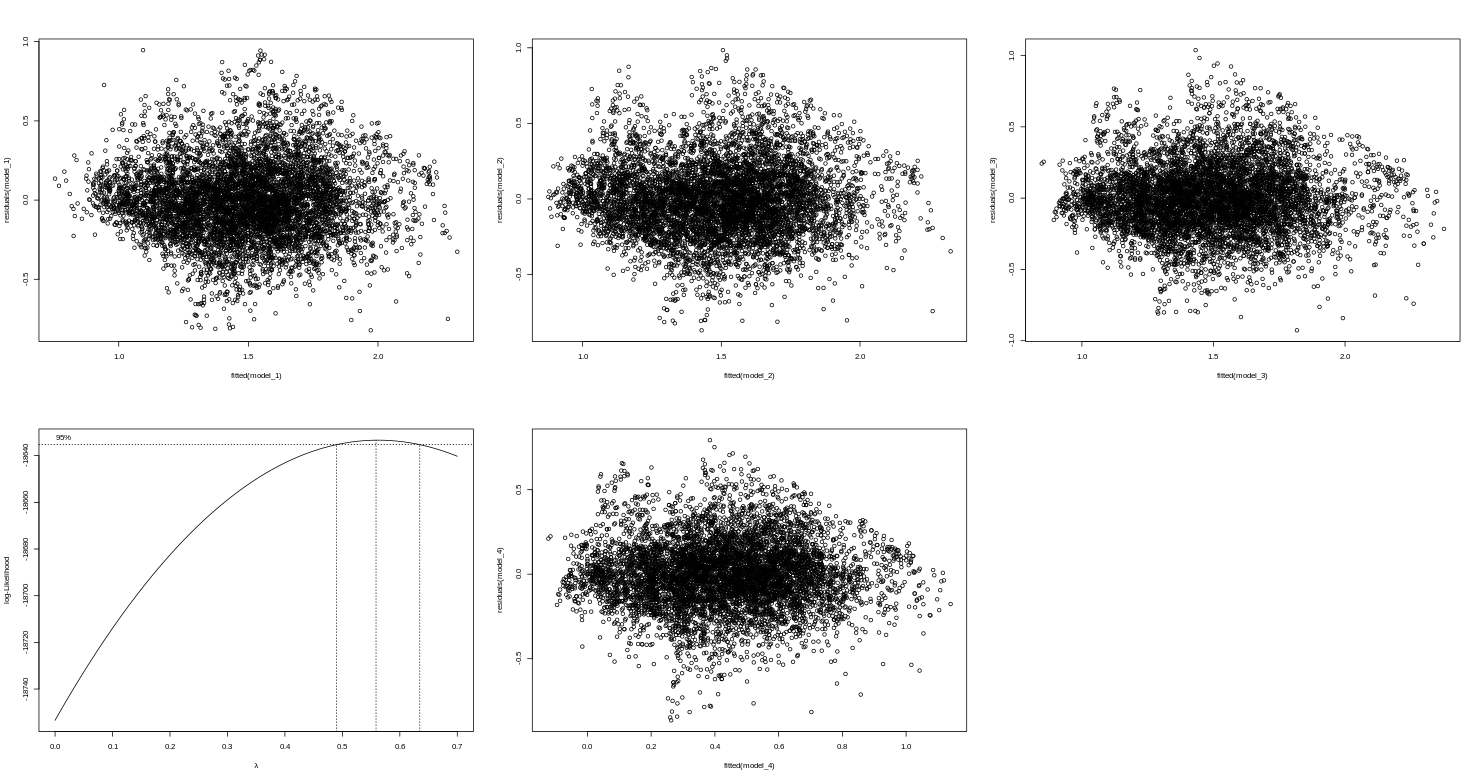

In [120]:
%%R -w 1480 -h 780 -u px
par(mfrow=c(2,3))
plot(residuals(model_1)~fitted(model_1))
plot(residuals(model_2)~fitted(model_2))
plot(residuals(model_3)~fitted(model_3))
boxcox(model_3,plotit=T, lambda = seq(0,.7,by=.1))
plot(residuals(model_4)~fitted(model_4))

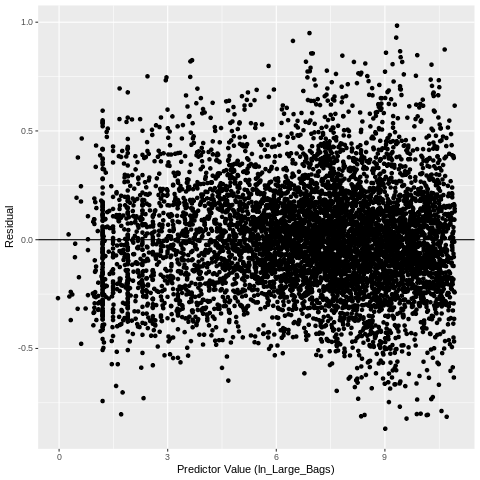

In [125]:
%%R
res <- data.frame(res=resid(model_2))
new_data <- cbind(data_clean, res)
ggplot(new_data, aes(y = res, x = ln_Large_Bags)) +
  geom_point() +
  geom_hline(yintercept = 0) +
  xlab("Predictor Value (ln_Large_Bags)") +
  ylab("Residual")

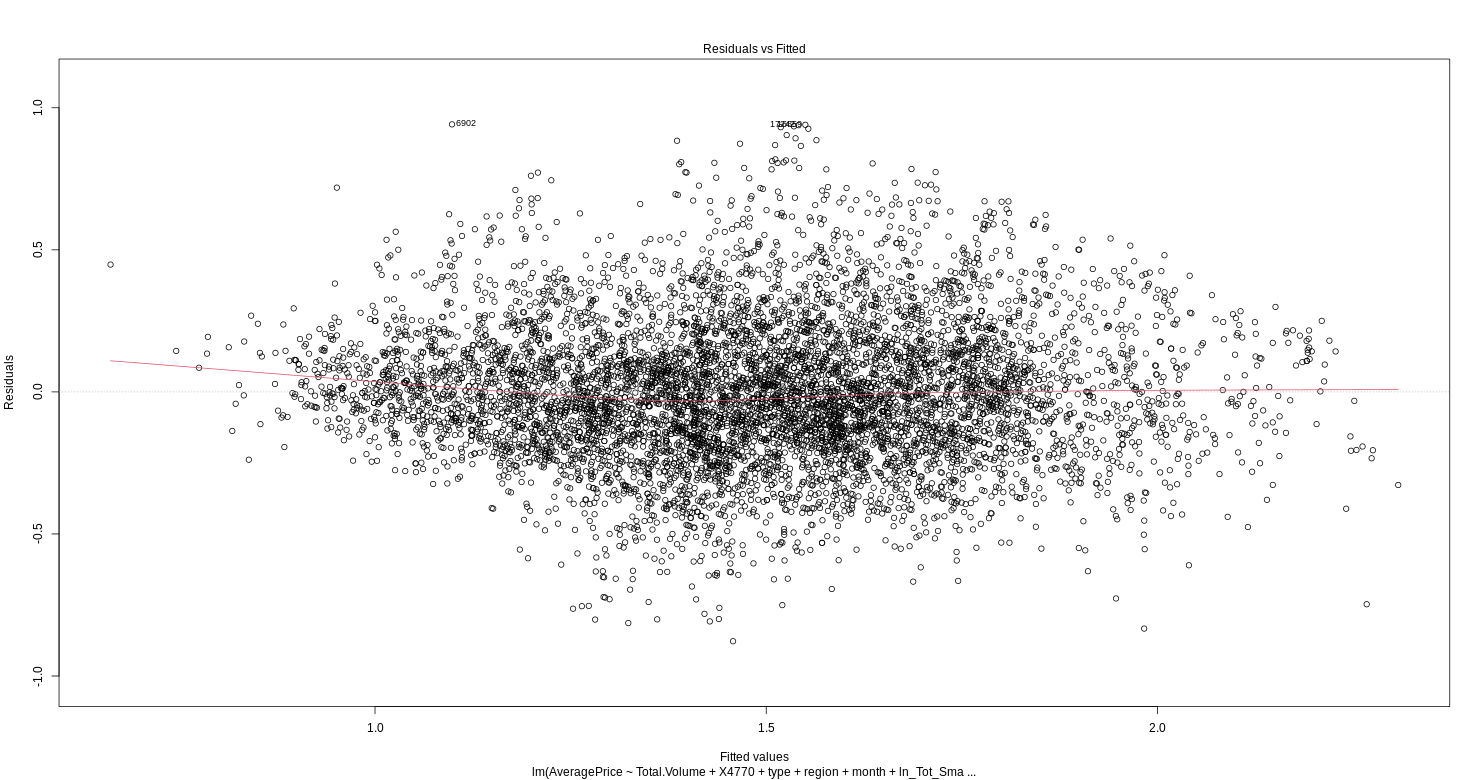

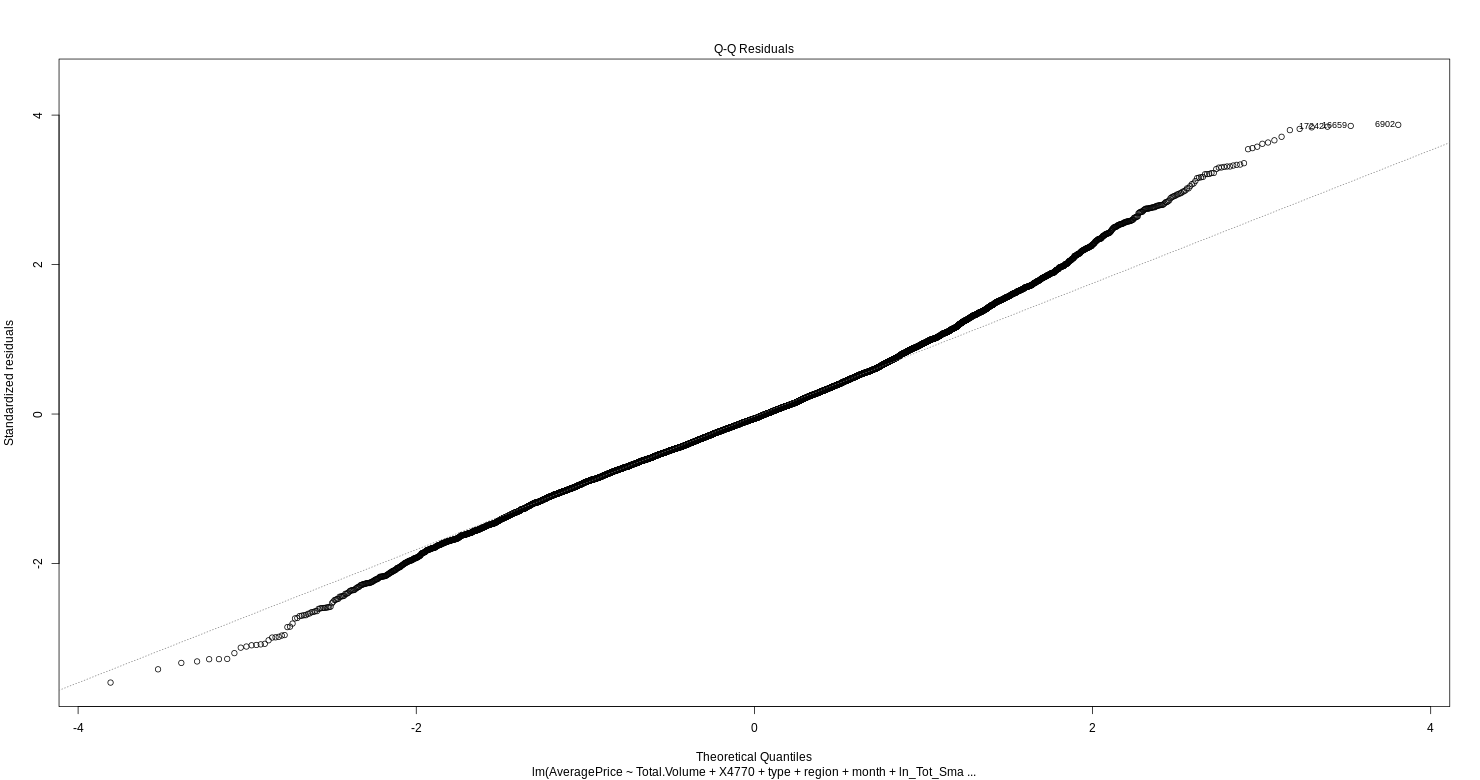

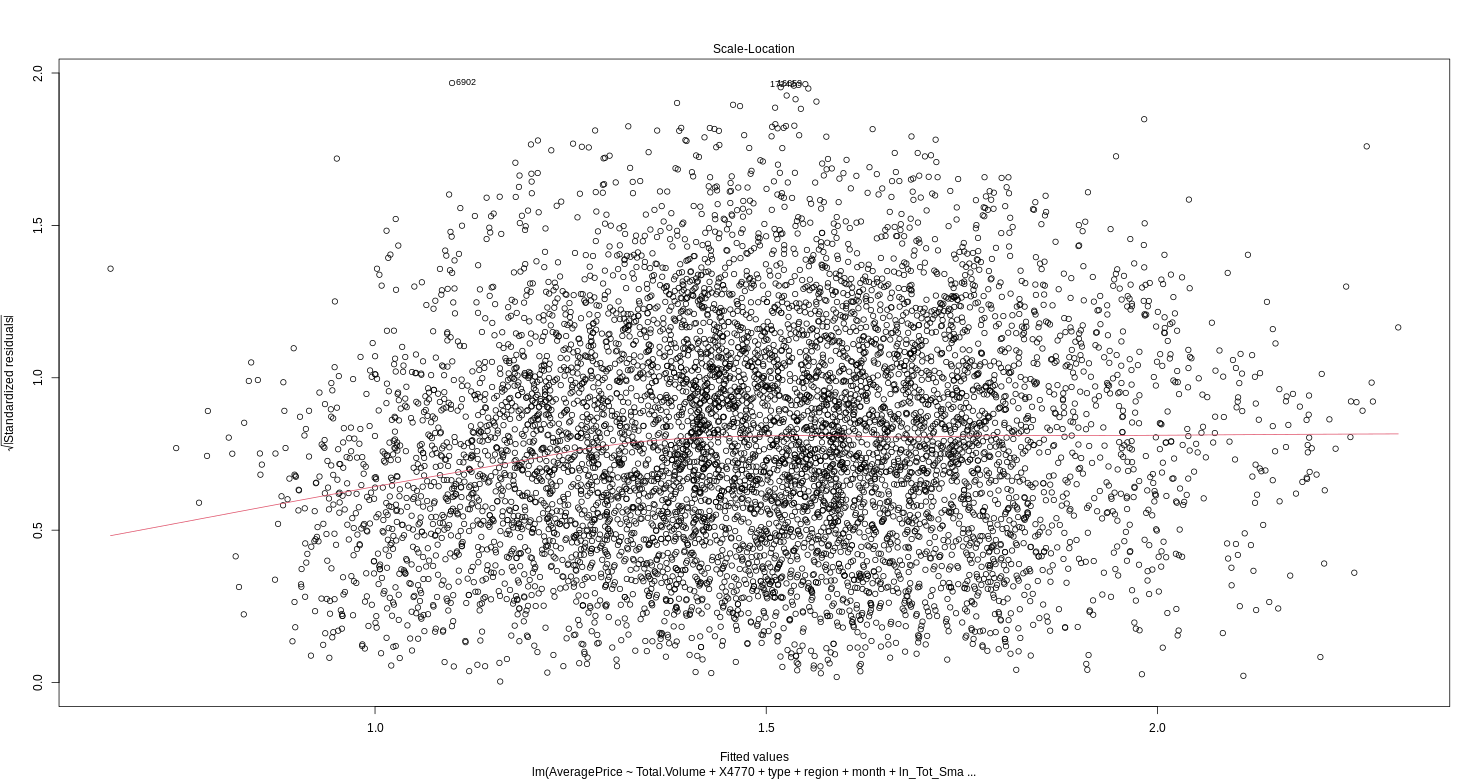

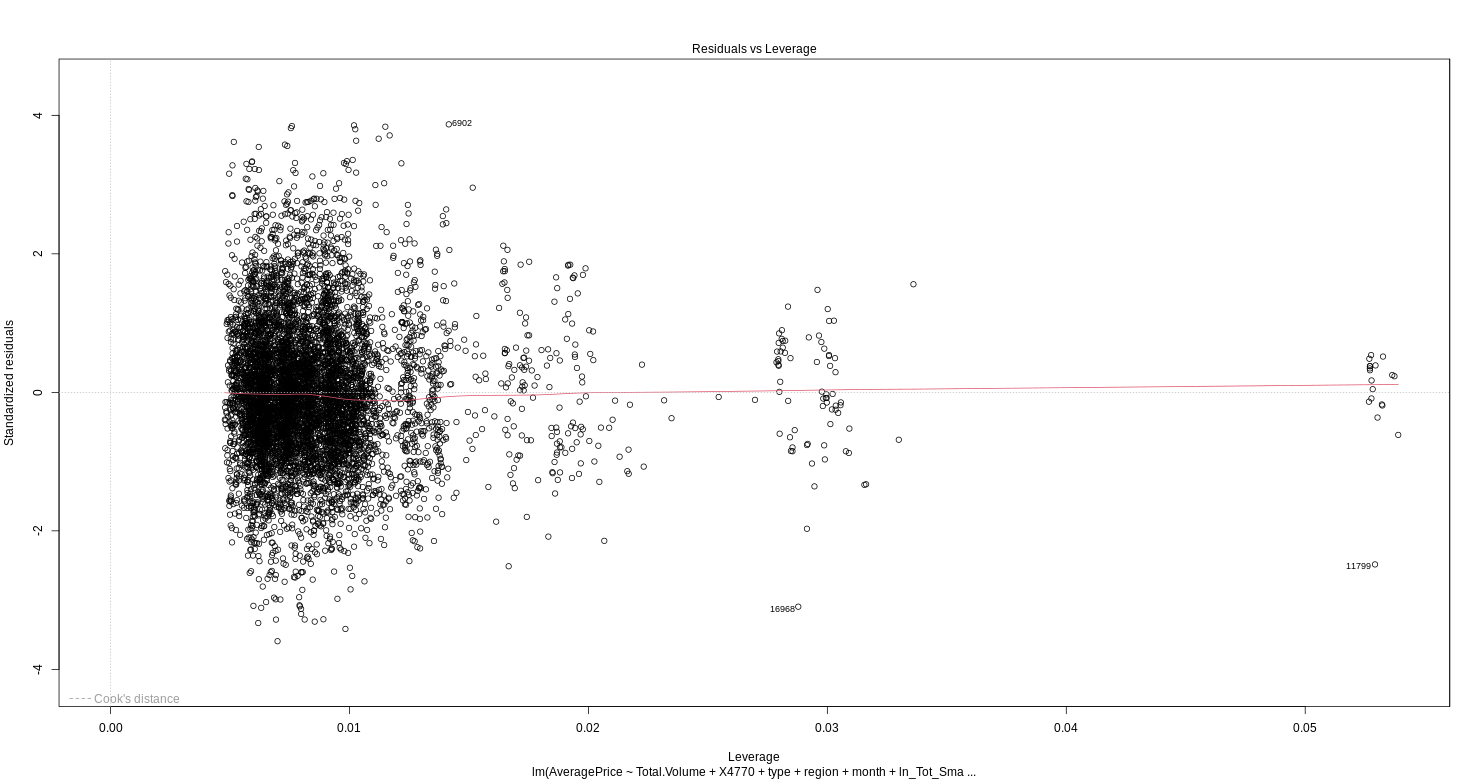

In [200]:
%%R -w 1480 -h 780 -u px
plot(model_1)

In [201]:
%%R
data_clean2 <- data_clean[, -c(11799,6902,16968)]

In [220]:
%%R
model_1t <- lm(AveragePrice ~ Total.Volume + X4770 + type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags , data= data_clean2)
summary(model_1t)


Call:
lm(formula = AveragePrice ~ Total.Volume + X4770 + type + region + 
    month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags, 
    data = data_clean2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.87762 -0.15467 -0.01491  0.13852  0.94156 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.498e+00  6.912e-02  21.676  < 2e-16 ***
Total.Volume              -7.158e-07  5.961e-08 -12.007  < 2e-16 ***
X4770                     -8.656e-06  1.682e-06  -5.147 2.72e-07 ***
typeorganic                1.415e-01  2.935e-02   4.820 1.46e-06 ***
regionAtlanta              7.378e-02  3.684e-02   2.003 0.045253 *  
regionBaltimoreWashington  1.976e-01  3.899e-02   5.069 4.11e-07 ***
regionBoise               -4.037e-02  3.022e-02  -1.336 0.181587    
regionBoston               2.752e-01  3.518e-02   7.821 5.99e-15 ***
regionBuffaloRochester     8.599e-02  3.156e-02   2.725 0.006448 ** 
regionCalifornia    

In [221]:
%%R
print(PRESS(model_1))
print(PRESS(model_1t))

[1] 429.5359
[1] 432.5025


In [228]:
%%R
test_data <- transform(test_data, ln_Tot_Vol = log(Total.Volume))
test_data <- transform(test_data, ln_Tot_Small = log(X4046))
test_data <- transform(test_data, ln_Tot_Med = log(X4225))
test_data <- transform(test_data, ln_Small_Bags = log(Small.Bags))
test_data <- transform(test_data, ln_Large_Bags = log(Large.Bags))
test_data$date <- ymd(test_data$Date)
test_data$month <- format(as.Date(test_data$date, format="%Y-%m-%d"),"%m")
test_data$month <- as.numeric(test_data$month)
cols_to_clean <- names(test_data)[sapply(test_data , is.numeric)]
data_clean<- test_data %>%
  mutate(across(cols_to_clean , ~detect_outlier(.,iqtimes=1.5)))
data_clean <- na.omit(data_clean)
model_3_test <- lm(AveragePrice ~  type + region + month + ln_Tot_Small + ln_Tot_Med + ln_Small_Bags + ln_Large_Bags + region:type, data= data_clean)
summary(model_3_test)


Call:
lm(formula = AveragePrice ~ type + region + month + ln_Tot_Small + 
    ln_Tot_Med + ln_Small_Bags + ln_Large_Bags + region:type, 
    data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9036 -0.1492 -0.0156  0.1377  0.8286 

Coefficients: (20 not defined because of singularities)
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            2.030664   0.164528  12.342  < 2e-16 ***
typeorganic                            0.064087   0.152500   0.420 0.674363    
regionAtlanta                          0.042930   0.186267   0.230 0.817750    
regionBaltimoreWashington              0.215774   0.144208   1.496 0.134777    
regionBoise                           -0.028868   0.074648  -0.387 0.699012    
regionBoston                           0.257786   0.121735   2.118 0.034359 *  
regionBuffaloRochester                 0.119926   0.065931   1.819 0.069100 .  
regionCalifornia                       0.460896 

## Prediction Interval for model_3

In [231]:
%%R
CL <- 0.95
prediction <- predict(model_3, data_clean, interval = "prediction", level = CL)
head(prediction)

        fit       lwr      upr
3  1.476665 0.9984405 1.954890
13 1.400299 0.9222207 1.878377
15 1.371853 0.8937855 1.849920
20 1.414643 0.9365058 1.892781
23 1.391017 0.9128877 1.869147
25 1.385949 0.9077932 1.864106


Yes the prediction proportion seems to be working correctly

## Conclusion


### After the Model Selection prcess and testing the the model usingt the test data model_3 has the highest $R^2$ at .5213